In [256]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import decimal
from scipy.integrate import simps


In [257]:
rc['legend.fontsize']=18
rc['axes.titlesize']=18
rc['lines.linewidth']=1.5
rc['lines.markersize']=8
rc['font.size']=18
rc['legend.handletextpad']= 0.2
rc['legend.frameon']=False
rc['text.usetex']=True
#print(rc.keys)

In [3]:
def tau_p(p1,k1,Nn):
    g=0.1
    return g*Nn**2/(np.pi**2*k1*p1**2)

In [4]:
def fit_func(x,a,b,c,d,e,f,g):
    return d*np.exp(-a*x)*(np.cos(b*x+c)+np.sin(f*x+g))+e

Text(0, 0.5, 'Fano factor $\\sigma_r^2/\\langle r\\rangle$')

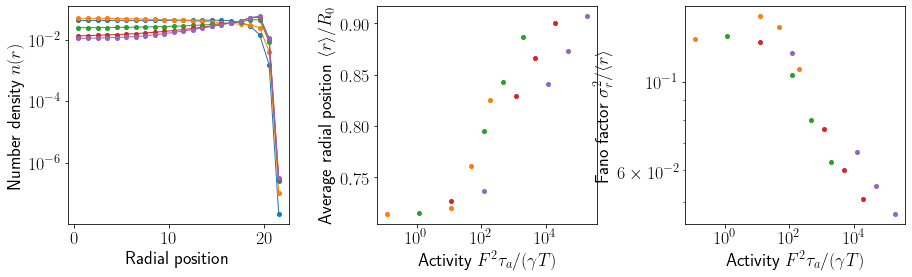

In [306]:
fig,axes=plt.subplots(1,3,figsize=(15,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})

# [[ax1,ax2],[ax3,ax4]]=axes
[ax1,ax2,ax3]=axes
ind=3

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
w=0
fpath='../../data/ROUSE_chainN100_confinedR0500/'
fpath='../../data/SAC/RDP/'
# fpath='../../data/ChrmAB_N500_R010_lowLC/RDP'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)

        npzfile=np.load(fpath+fname)
       
        b_act=F**2*Ta/(0.1*0.0083*T)

        betas.append(b_act)
        Ts.append(T)
        Tas.append(Ta)
        Fs.append(F)

        Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
        Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
        Rsd=np.sqrt(simps((npzfile['bins']-Rav)**2*4*np.pi*npzfile['bins']*npzfile['hist']/1200,npzfile['bins']))
        # print(Rav)
        Rmax.append((F,Ta,b_act,Rav/R0, Rsd**2/Rav))
        

        # if b_act not in [0.0, 2.0,40.0, 160.0, 180.0]: continue
        # if T==0.5 and F==0.1 and (Ta==10 or Ta==50) and R0==10 and (kb==5 ) and nn==100:
        if F==0.0 or F==1:
            
            # print(npzfile['bins'].shape[0], npzfile['hist'].shape,R0)
            # if F==0.008: continue
            bin_w=R0/npzfile['bins'].shape[0]
            # if Ta>t1: continue
            lab=format(b_act,'.1E')
            ax1.plot(npzfile['bins'],npzfile['hist'], '.-',label='$\\beta_{act}$='+lab,lw=1)
    

for Ta in np.unique(Tas):
    # print(Ta)
    Rmax_Ta=sorted([xx for xx in Rmax if xx[1]==Ta], key=lambda x: x[2])

    ax2.plot([xx[2] for xx in Rmax_Ta],[xx[3] for xx in Rmax_Ta],'.')
    ax3.plot([xx[2] for xx in Rmax_Ta],[xx[4] for xx in Rmax_Ta],'.')

def fit(xx,a,b):
    return (1-b*(1+xx)**a)
    # return a*(1-1/np.sqrt(b*xx))
    
# popt,pcov=curve_fit(fit,[xx[2] for xx in Rmax],[xx[3] for xx in Rmax])

# ax2.plot(np.logspace(-3,5,50), fit(np.logspace(-3,5,50),popt[0],popt[1]))
            
# print(w,len(X))
# for axi in axes.flatten():
    # handles, labels = axi.get_legend_handles_labels()
    # #print(labels)
    # hl = sorted(zip(handles, labels),
    #         key=lambda x: float(x[1].split('=')[1].replace('$','')))
    # handles2, labels2 = zip(*hl)
    # #print(labels2)
    # axi.legend(handles2, labels2,)
    # axi.legend(loc='lower left',bbox_to_anchor=(1.1,0.1))
    # axi.set_yscale('log')
    # axi.set_xscale('log')
    # axi.grid(True)
    # axi.set_xlim([-1,6])
    
ax1.set_xlabel('Radial position')
ax1.set_ylabel('Number density $n(r)$')
# ax1.set_ylim([1e-7,1e-3])
ax1.semilogy()
# ax1.loglog()


ax2.set_ylabel('Average radial position $\\langle r\\rangle/R_0$')
ax2.set_xlabel('Activity $F^2\\tau_a/(\\gamma T)$')
# ax2.set_xlim(0,30)
ax2.semilogx()
ax3.loglog()
# ax2.set_ylim(0,1)
# plt.colorbar(m)

ax3.set_xlabel('Activity $F^2\\tau_a/(\\gamma T)$')
ax3.set_ylabel('Fano factor $\\sigma_r^2/\\langle r\\rangle$')



# fig.savefig('../../plots/Rouse/avg_rad_pos_act.png', dpi=300, bbox_inches='tight')


No handles with labels found to put in legend.
No handles with labels found to put in legend.


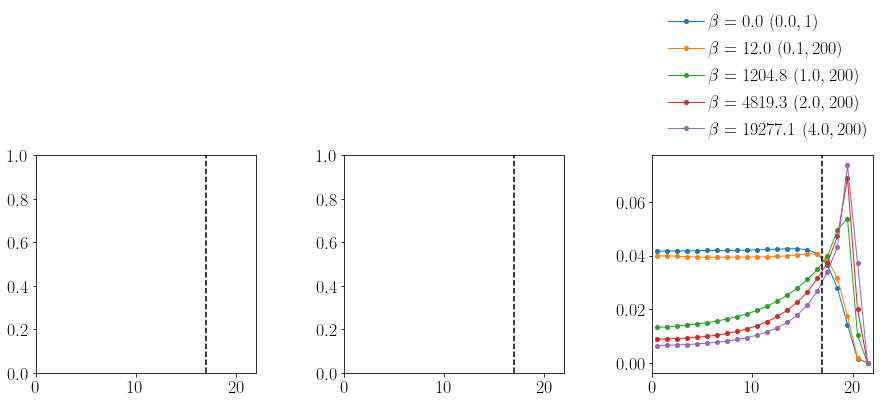

In [371]:
fig,axes=plt.subplots(1,3,figsize=(15,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})

# [[ax1,ax2],[ax3,ax4]]=axes
[ax1,ax2,ax3]=axes
ind=3

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
w=0

fpath='../../data/ChrmAB_N500_R010_lowLC/RDP/'
fpath='../../data/SAC/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens' in fname:# and 'rep2' in fname:
        # print(fname.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)

        npzfile=np.load(fpath+fname)
        beta=F**2*Ta/(0.1*T*0.0083)

        if F==0 or Ta==200:#F==0.0 or (F==3 and (Ta==1 or Ta==100)):
            if 'RadNumDens_A' in fname:
                ax1.plot(npzfile['bins'],npzfile['hist'], '.-',label='$F={:.1f},{:.1f}$'.format(beta,F),lw=1)

            elif 'RadNumDens_B' in fname:
                ax2.plot(npzfile['bins'],npzfile['hist'], '.-',label='$F={:.1f}$'.format(F),lw=1)
            else:
                ax3.plot(npzfile['bins'],npzfile['hist'], '.-',label='$\\beta={:.1f}\ ({:.1f},{:.0f})$'.format(beta,F,Ta),lw=1)
        # if F==0 or Ta==20:
        #     ax2.plot(npzfile['bins'],npzfile['hist'], '.-',label='$\\beta={:.1f}\ ({:.1f},{:.0f})$'.format(beta,F,Ta),lw=1)
        # if F==0 or Ta==200:
        #     ax1.plot(npzfile['bins'],npzfile['hist'], '.-',label='$\\beta={:.1f}\ ({:.1f},{:.0f})$'.format(beta,F,Ta),lw=1)

for axi in axes.flatten():
    axi.axvline(R0-3,c='k',ls='--')    
    axi.set_xlim(0,R0+2)
    axi.legend(loc='lower left', bbox_to_anchor=(0,1))

# ax1.set_xlabel('Radial position')
# ax1.set_ylabel('Number density $n(r)$')
# # ax1.set_ylim([1e-7,1e-3])
# ax1.semilogy()
# # ax1.loglog()



# ax2.set_ylabel('Average radial position $\\langle r\\rangle/R_0$')
# ax2.set_xlabel('Activity $F^2\\tau_a/(\\gamma T)$')
# ax2.semilogx()
# ax3.loglog()
# # ax2.set_ylim(0,1)
# # plt.colorbar(m)

# ax3.set_xlabel('Activity $F^2\\tau_a/(\\gamma T)$')
# ax3.set_ylabel('Fano factor $\\sigma_r^2/\\langle r\\rangle$')

# ax3.axvline(17,c='k',ls='--')

# fig.savefig('../../plots/Rouse/avg_rad_pos_act.png', dpi=300, bbox_inches='tight')


10


[]

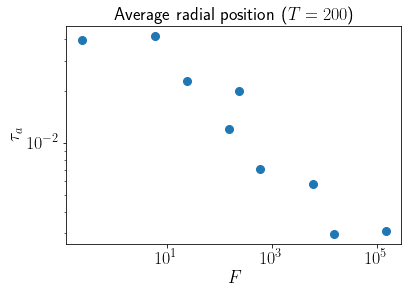

In [360]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=200
fpath='../../data/SAC_AB/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens_A' in fname and 'rep1' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        if kb==5: continue
        if T==T0:
            npzfile=np.load(fpath+fname)
       
            b_act=F**2*Ta/(0.1*0.0083*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
            Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
            Rsd=np.sqrt(simps((npzfile['bins']-Rav)**2*4*np.pi*npzfile['bins']*npzfile['hist']/1200,npzfile['bins']))
            # print(Rav)

            Rav=np.mean(npzfile['hist'][1:5])
            Rmax.append((F,Ta,b_act,Rav, Rsd**2/Rav))
        
print(len(Rmax))
Xi,Yi=np.meshgrid(np.logspace(-1,1,10),np.logspace(0,3,10))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,[xx[3] for xx in Rmax])#, kind='geom')
Zi=interpZ(Xi,Yi)
# plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,0.2,0.01),cmap='RdBu')
# plt.colorbar()
plt.plot([xx[2] for xx in Rmax],[xx[3] for xx in Rmax],'o')
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[10],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

# plt.plot(Fs,Tas,'.',c='b',markersize=5)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
plt.title('Average radial position ($T={:.0f}$)'.format(T0))

plt.loglog()
# plt.savefig('../../plots/Rouse/avg_radial_pos_Ft_T200.png', dpi=300,bbox_inches='tight')

[]

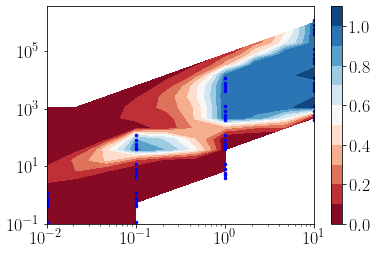

In [131]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
fpath='../../data/ROUSE_chainN100_confinedR0500/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        
        npzfile=np.load(fpath+fname)
    
        b_act=F**2*Ta/(0.1*0.0083*T)

        betas.append(b_act)
        Ts.append(T)
        Tas.append(Ta)
        Fs.append(F)

        Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
        Rmax.append(Rm/500)

Xi,Yi=np.meshgrid(np.logspace(-2,1,10),np.logspace(-1,6,20))
triang=tri.Triangulation(Fs,betas)
interpZ=tri.LinearTriInterpolator(triang,Rmax)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,1.2,0.1),cmap='RdBu')
plt.colorbar()

# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Fs,betas,'.',c='b',markersize=5)
# plt.xlim(1,1e3)

plt.loglog()


[]

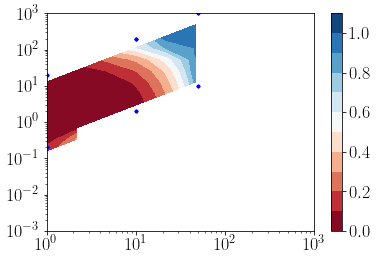

In [122]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
for fpath in ['../../data/ROUSE_chain_confined_Ns/']:#,'../../data/ROUSE_chain_confined_Ns/N300/']:

    for fname in os.listdir(fpath):
        if '.npz' in fname and 'RDP' in fname:
            # print(fname)#.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            if R0!=10: continue
            npzfile=np.load(fpath+fname)
            # print(npzfile['bins'].shape)
        
            b_act=F**2*Ta/(0.1*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist'][0]==npzfile['hist'][0].max())][0]
            Rmax.append(Rm/R0)

Xi,Yi=np.meshgrid(np.logspace(0,3,10),np.logspace(-3,3,20))
triang=tri.Triangulation(Tas, betas)
interpZ=tri.LinearTriInterpolator(triang,Rmax)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,1.2,0.1),cmap='RdBu')
plt.colorbar()

# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Tas,betas,'.',c='b',markersize=5)

plt.loglog()


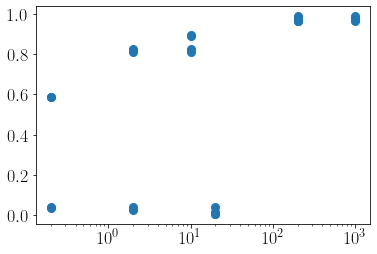

In [123]:
plt.semilogx(betas,Rmax,'o')

Text(0, 0.5, '$F^2\\tau_a/(\\gamma T)$')

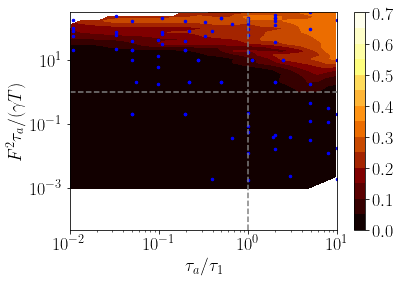

In [598]:
Xi,Yi=np.meshgrid(np.logspace(-3,2,50),np.logspace(-3,4,60))
triang=tri.Triangulation(X,Y)
interpZ=tri.LinearTriInterpolator(triang,Z)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.linspace(0,0.7,15),cmap='afmhot')#,alpha=0.6)
        #ax.contour(Xi, Yi, Zi,colors='k',levels=levels,linewidths=0.3)


plt.plot(X,Y,'.',c='b',markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,10)
plt.ylim(5e-5,3e2)
plt.axhline(1,c='0.5',ls='--',)
plt.axvline(1,c='0.5',ls='--',)

# plt.grid(True,alpha=0.5,which='both')

plt.colorbar()
plt.xlabel('$\\tau_a/\\tau_1$')
plt.ylabel('$F^2\\tau_a/(\gamma T)$')
# plt.savefig('../plots/Rouse/RC_RDP_phase_diag.png',dpi=300, bbox_inches='tight')

#confined_N300 and _N100_new

In [545]:
f=0.003
T=0.8
Ta=350
t1=tau_p(1,5,300)
print('{:.1f} {:.3f} {:.3f}'.format(t1, Ta/t1,f**2*Ta/(0.02*T)))


182.4 1.919 0.197


In [30]:
x=1000
y=format(x,'.2E')
print(y, type(y))
 

1.00E+03 <class 'str'>
